# Goal

* Ordination plots of sample betadata 

# Var

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/modulating_factors/ordination/IndD/'

# phyloseq
physeq_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/phyloseq/physeq_r5k.RDS'

# beta-div distance matrices
beta_div_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/diversity/beta_div.RDS'


# Init

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(stringr)
library(phyloseq)

source('/ebio/abt3_projects/Georg_animal_feces/code/init.R') 
source('/ebio/abt3_projects/Georg_animal_feces/code/itol.R') 


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
set.seed(9374)

In [4]:
make_dir(work_dir)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/modulating_factors/ordination/IndD/ 


## Functions

In [5]:
#' Ordering distance matrixes
#' d = distance matrix (dist class)
#' x = vector to order dist by
dist_mtx_order = function(d, x){
    m = d %>% as.matrix
    d = as.dist(m[x,x])
    return(d)
}

In [6]:
pcoa = function(id, dist_list, make_plot=TRUE){
    # making PCoA plot 
    # id = list name
    # dist_list = list of distance matrixes
    # make_plt = create plot?
    
    d = dist_list[[id]]
    # using cmdscale for getting PCoA 
    r = cmdscale(d, eig=TRUE)
    perc_var_exp = r$eig / sum(r$eig)
    
    x = as.data.frame(r$points)
    x$sampleID = id
    r$points = x
    
    if(make_plot){
        options(repr.plot.width=4, repr.plot.height=3.5)
        x = 1:5
        plot(x, perc_var_exp[x], main=id)
    }
    
    return(r)
}

In [7]:
#' function for making ggplot2 plots
plot_pcoa = function(df, x_color='class', x_lab='PC1', y_lab='PC2'){
    AES = aes_string('PC1', 'PC2', color=x_color)
    ggplot(df, AES) +
        geom_point(alpha=0.5) +
        facet_wrap(~ D, scales='free') +
        labs(x=x_lab, y=y_lab) +
        theme_bw() +
        theme(
            legend.title=element_text(size=12),
            legend.text=element_text(size=12)
        )

}

In [8]:
#' coverting distance to data.frame
get_points = function(mds_list){
    # pulling out PCoA points
    df = mds_list$points %>% as.data.frame
    df$Sample = rownames(df)
    return(df)
}

# Load

In [9]:
# beta diveristy
d = readRDS(beta_div_file )
lapply(d, function(x) x %>% as.vector %>% summary)

$bray_curtis
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1104  0.9984  1.0000  0.9890  1.0000  1.0000 

$jaccard
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3886  0.9956  1.0000  0.9912  1.0000  1.0000 

$unweighted_unifrac
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2149  0.7783  0.8494  0.8361  0.9163  0.9881 

$weighted_unifrac
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02332 0.46492 0.55024 0.53904 0.62490 0.94211 


In [10]:
# metadata
metadata = readRDS(physeq_file) %>%
    sample_data %>%
    mutate(X.SampleID = rownames(.),
           digestive_system_detail = gsub('^_', '', digestive_system_detail),
           digestive_system_detail = gsub(' *_ *', '_', digestive_system_detail)) %>%
    as.data.frame

metadata %>% dfhead

Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

[1] 213 171


X.SampleID,BarcodeSequence,LinkerPrimerSequence,Primer,ReversePrimer,Barcode_ID,sample_number,host_subject_id,host_german_name,host_common_name,⋯,wellplate_position_Illumina,Cornell_Dilution_DNA_Illumina,Num_Illumina,Num,sorting_454,comments_additional,DNA_box_20180622,sample_vol_20180622,sample_label_20180622,Description
X1.Eurasian.Beaver,ACTCACGGTATG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0049,1,1,Biber,Eurasian.Beaver,⋯,B12,4,120,18,18,NA,1,20,1,NA
X101.Horse,ACGACGTCTTAG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0030,101,101,Hauspferd,Horse,⋯,E8,16,344,160,160,NA,2,20,101,NA
X102.Kulan,ACGAGTGCTATC,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0031,102,102,Khulan,Kulan,⋯,E9,16,345,161,161,NA,2,20,102,NA


# Format

In [11]:
# filtering distance matrix
filter_matrix = function(m, samples){
    m = m %>% as.matrix
    as.dist(m[samples,samples])
}
d = lapply(d, filter_matrix, samples=metadata$X.SampleID) 
lapply(d, function(x) x %>% as.vector %>% summary)

$bray_curtis
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1104  0.9984  1.0000  0.9890  1.0000  1.0000 

$jaccard
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3886  0.9956  1.0000  0.9912  1.0000  1.0000 

$unweighted_unifrac
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2149  0.7783  0.8494  0.8361  0.9163  0.9881 

$weighted_unifrac
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02332 0.46492 0.55024 0.53904 0.62490 0.94211 


In [12]:
# overlap of labels
setdiff(metadata$X.SampleID, labels(d[[1]])) %>% print
setdiff(labels(d[[1]]), metadata$X.SampleID) %>% print

character(0)
character(0)


In [13]:
# formatting
metadata = metadata %>%
    mutate(diet = gsub(' $', '', diet)) %>%
    filter(X.SampleID %in% labels(d[[1]])) %>%
    mutate(Nanodrop_ng_per_ul_DNA = Nanodrop_ng_per_ul_DNA %>% as.Num,
           Picogreen_ng_ul = Picogreen_ng_ul %>% as.Num,
           collection_date = collection_date %>% as.character,
           collection_date = ifelse(collection_date=='Autumn 2013', '01.10.13', collection_date),
           collection_date = as.Date(collection_date, format='%Y-%m-%d'),
           collection_bin = ntile(collection_date, 10)) 

metadata %>% dfhead

Warning message in as.Num(.):
“NAs introduced by coercion”

[1] 213 172


X.SampleID,BarcodeSequence,LinkerPrimerSequence,Primer,ReversePrimer,Barcode_ID,sample_number,host_subject_id,host_german_name,host_common_name,⋯,Cornell_Dilution_DNA_Illumina,Num_Illumina,Num,sorting_454,comments_additional,DNA_box_20180622,sample_vol_20180622,sample_label_20180622,Description,collection_bin
X1.Eurasian.Beaver,ACTCACGGTATG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0049,1,1,Biber,Eurasian.Beaver,⋯,4,120,18,18,NA,1,20,1,NA,NA
X101.Horse,ACGACGTCTTAG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0030,101,101,Hauspferd,Horse,⋯,16,344,160,160,NA,2,20,101,NA,NA
X102.Kulan,ACGAGTGCTATC,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0031,102,102,Khulan,Kulan,⋯,16,345,161,161,NA,2,20,102,NA,NA


## Filtering distance matrices

In [14]:
# ordering and filtering distance matrix
## status
cat('Pre-filtering\n')
plyr::llply(d, function(x) x %>% labels %>% as.vector %>% length) %>% print
## ordering by metadata
d = plyr::llply(d, dist_mtx_order, x=as.vector(metadata$X.SampleID))
## status
cat('Post-filtering\n')
plyr::llply(d, function(x) x %>% labels %>% as.vector %>% length) %>% print

Pre-filtering
$bray_curtis
[1] 213

$jaccard
[1] 213

$unweighted_unifrac
[1] 213

$weighted_unifrac
[1] 213

Post-filtering
$bray_curtis
[1] 213

$jaccard
[1] 213

$unweighted_unifrac
[1] 213

$weighted_unifrac
[1] 213



In [15]:
# check: number of samples per animal
metadata %>% 
    group_by(host_subject_id) %>%
    summarize(n=n()) %>%
    ungroup() %>%
    .$n %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1       1       1       1       1       1 

# PCoA

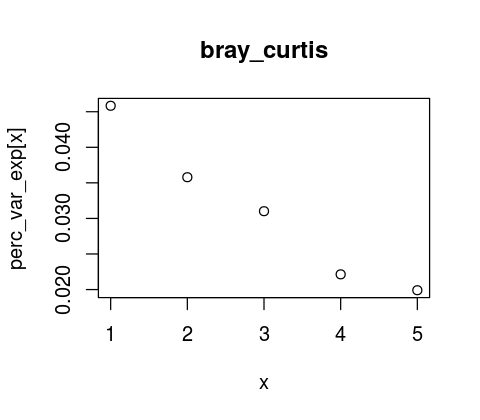

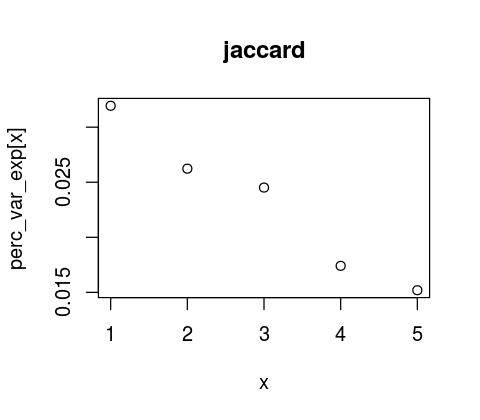

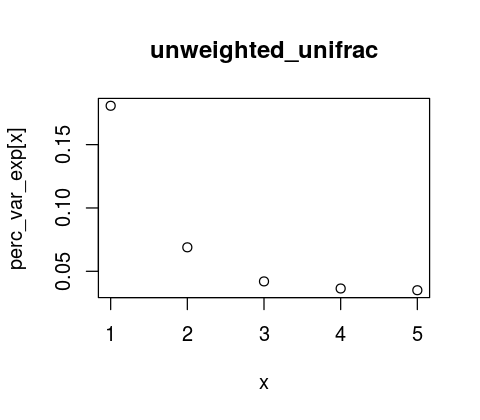

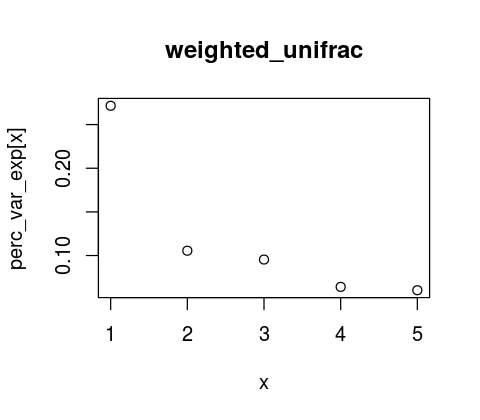

In [16]:
d_pcoa = plyr::llply(names(d), pcoa, dist_list=d)

In [17]:
# percent variance explained
d_pcoa %>% lapply(function(x) (x$eig / sum(x$eig) * 100) %>% head) %>% print

[[1]]
[1] 4.583667 3.579400 3.101571 2.213712 1.990542 1.843775

[[2]]
[1] 3.194009 2.623183 2.451566 1.741018 1.519697 1.318407

[[3]]
[1] 18.069442  6.893026  4.200626  3.640586  3.504486  2.069971

[[4]]
[1] 27.154148 10.552014  9.540807  6.407381  6.026779  5.483205



## Plotting

In [18]:
# coverting to data.frame
get_points = function(mds_list){
    # pulling out PCoA points
    df = mds_list$points %>% as.data.frame
    df$Sample = rownames(df)
    return(df)
}

mds = plyr::ldply(d_pcoa, get_points)
colnames(mds) = c('PC1', 'PC2', 'D', 'Sample')

# status
mds %>% dfhead

[1] 852   4


PC1,PC2,D,Sample
-0.02347029,-0.0196975,bray_curtis,X1.Eurasian.Beaver
-0.03998096,0.0034305,bray_curtis,X101.Horse
-0.11039050,0.2646508,bray_curtis,X102.Kulan


In [19]:
# joining with metadata
mds_j = mds %>%
    inner_join(metadata, c('Sample'='X.SampleID')) 

mds_j$Sample %>% unique %>% length %>% print
mds_j %>% dfhead

[1] 213
[1] 852 175


PC1,PC2,D,Sample,BarcodeSequence,LinkerPrimerSequence,Primer,ReversePrimer,Barcode_ID,sample_number,⋯,Cornell_Dilution_DNA_Illumina,Num_Illumina,Num,sorting_454,comments_additional,DNA_box_20180622,sample_vol_20180622,sample_label_20180622,Description,collection_bin
-0.02347029,-0.0196975,bray_curtis,X1.Eurasian.Beaver,ACTCACGGTATG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0049,1,⋯,4,120,18,18,NA,1,20,1,NA,NA
-0.03998096,0.0034305,bray_curtis,X101.Horse,ACGACGTCTTAG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0030,101,⋯,16,344,160,160,NA,2,20,101,NA,NA
-0.11039050,0.2646508,bray_curtis,X102.Kulan,ACGAGTGCTATC,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0031,102,⋯,16,345,161,161,NA,2,20,102,NA,NA


In [20]:
# renaming
renaming = c(
    'bray_curtis' = 'Bray Curtis',
    'jaccard' = 'Jaccard',
    'unweighted_unifrac' = 'Unweighted Unifrac', 
    'weighted_unifrac' = 'Weighted Unifrac'
) %>% as.data.frame
colnames(renaming) = c('new_name')
renaming$old_name = rownames(renaming)

# renmaing
mds_j = mds_j %>%
    inner_join(renaming, c('D'='old_name')) %>%
    dplyr::select(-D) %>%
    dplyr::rename('D' = new_name)

mds_j$D %>% table
mds_j %>% dfhead

.
       Bray Curtis            Jaccard Unweighted Unifrac   Weighted Unifrac 
               213                213                213                213 

[1] 852 175


PC1,PC2,Sample,BarcodeSequence,LinkerPrimerSequence,Primer,ReversePrimer,Barcode_ID,sample_number,host_subject_id,⋯,Num_Illumina,Num,sorting_454,comments_additional,DNA_box_20180622,sample_vol_20180622,sample_label_20180622,Description,collection_bin,D
-0.02347029,-0.0196975,X1.Eurasian.Beaver,ACTCACGGTATG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0049,1,1,⋯,120,18,18,NA,1,20,1,NA,NA,Bray Curtis
-0.03998096,0.0034305,X101.Horse,ACGACGTCTTAG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0030,101,101,⋯,344,160,160,NA,2,20,101,NA,NA,Bray Curtis
-0.11039050,0.2646508,X102.Kulan,ACGAGTGCTATC,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0031,102,102,⋯,345,161,161,NA,2,20,102,NA,NA,Bray Curtis


In [21]:
just_unifrac = c('Unweighted Unifrac', 'Weighted Unifrac')

## Taxonomy

File written: /ebio/abt3_projects/Georg_animal_feces/notebooks/16S/3_modulating_factors/ordination/.figures/IndD_pcoa-all-metrics_tax.pdf 


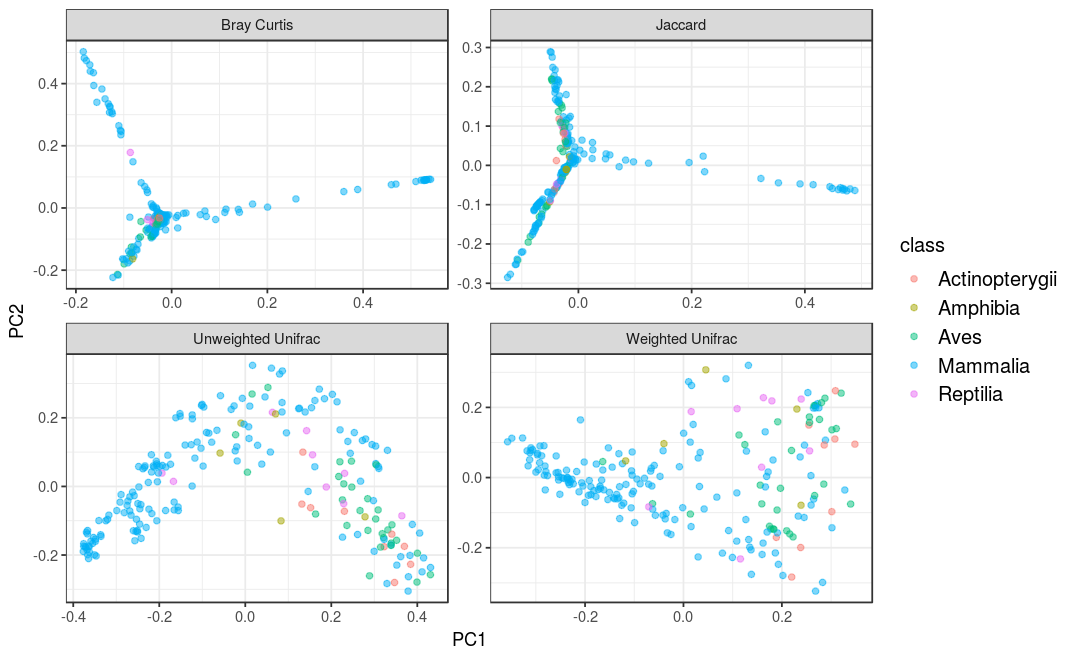

In [22]:
p = plot_pcoa(mds_j)
options(repr.plot.width=9, repr.plot.height=5.5)
plot_write(p, file='IndD_pcoa-all-metrics_tax.pdf')

File written: /ebio/abt3_projects/Georg_animal_feces/notebooks/16S/3_modulating_factors/ordination/.figures/IndD_pcoa-unifrac_tax.pdf 


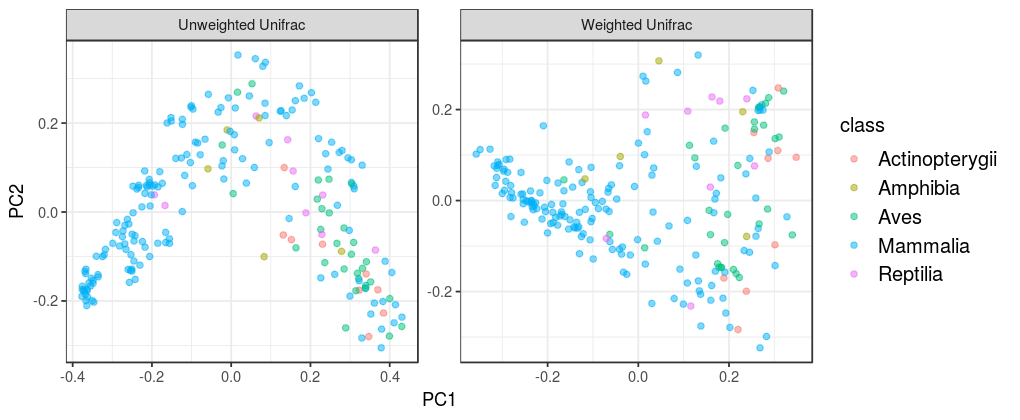

In [23]:
p_tax = plot_pcoa(mds_j %>% filter(D %in% just_unifrac))
options(repr.plot.width=8.5, repr.plot.height=3.5)
plot_write(p_tax, file='IndD_pcoa-unifrac_tax.pdf')

## Diet

File written: /ebio/abt3_projects/Georg_animal_feces/notebooks/16S/3_modulating_factors/ordination/.figures/IndD_pcoa-unifrac_diet.pdf 


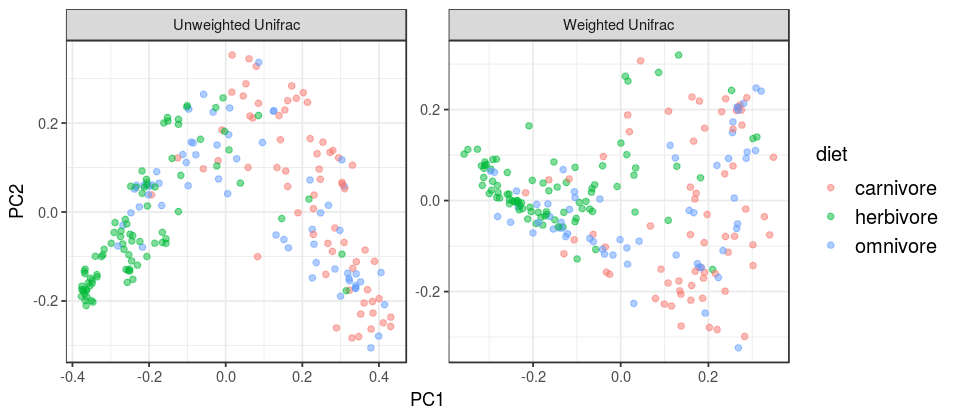

In [24]:
p_diet = plot_pcoa(mds_j %>% filter(D %in% just_unifrac), 'diet')
options(repr.plot.width=8, repr.plot.height=3.5)
plot_write(p_diet, file='IndD_pcoa-unifrac_diet.pdf')

## Digestive system

File written: /ebio/abt3_projects/Georg_animal_feces/notebooks/16S/3_modulating_factors/ordination/.figures/IndD_pcoa-unifrac_digest-sys.pdf 


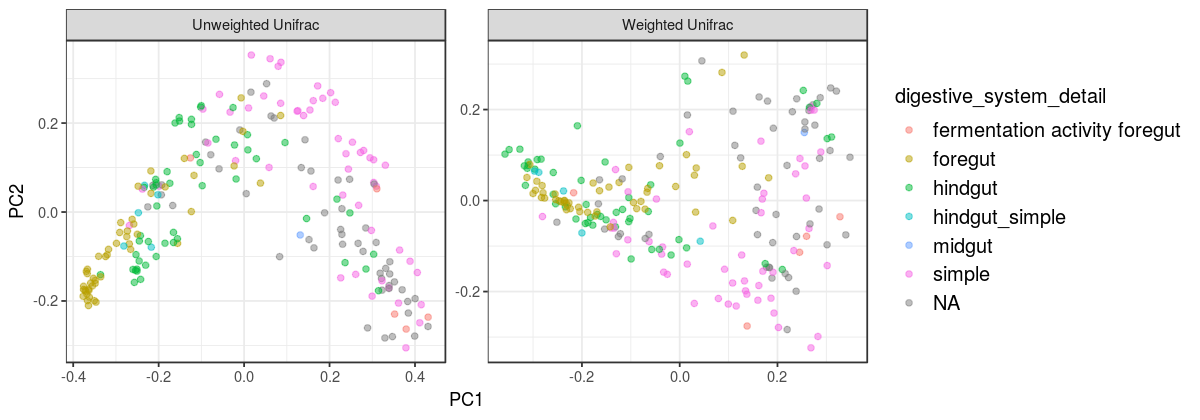

In [25]:
p_ds = plot_pcoa(mds_j %>% filter(D %in% just_unifrac), 'digestive_system_detail')
options(repr.plot.width=10, repr.plot.height=3.5)
plot_write(p_ds, file='IndD_pcoa-unifrac_digest-sys.pdf')

## Habitat

File written: /ebio/abt3_projects/Georg_animal_feces/notebooks/16S/3_modulating_factors/ordination/.figures/IndD_pcoa-unifrac_habitat.pdf 


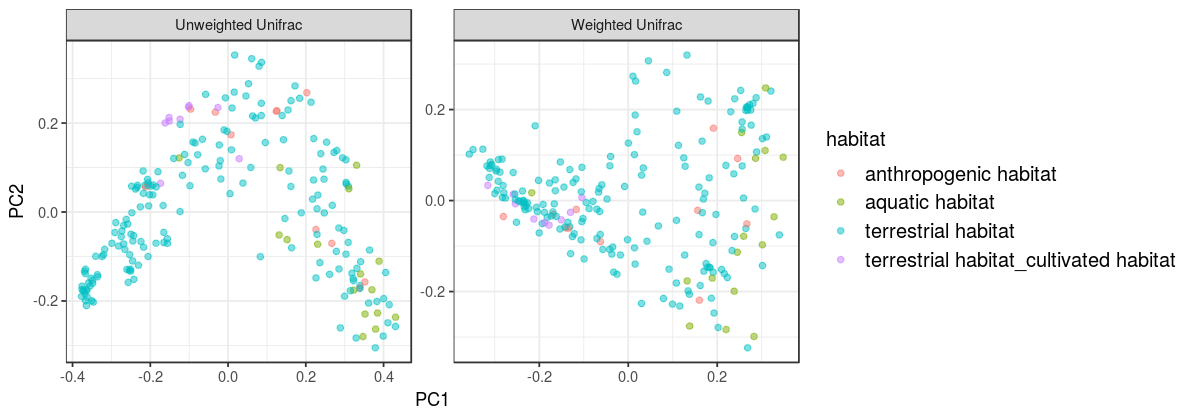

In [26]:
p_habitat = plot_pcoa(mds_j %>% filter(D %in% just_unifrac), 'habitat')
options(repr.plot.width=10, repr.plot.height=3.5)
plot_write(p_habitat, file='IndD_pcoa-unifrac_habitat.pdf')

File written: /ebio/abt3_projects/Georg_animal_feces/notebooks/16S/3_modulating_factors/ordination/.figures/IndD_pcoa-unifrac_habitat-detail.pdf 


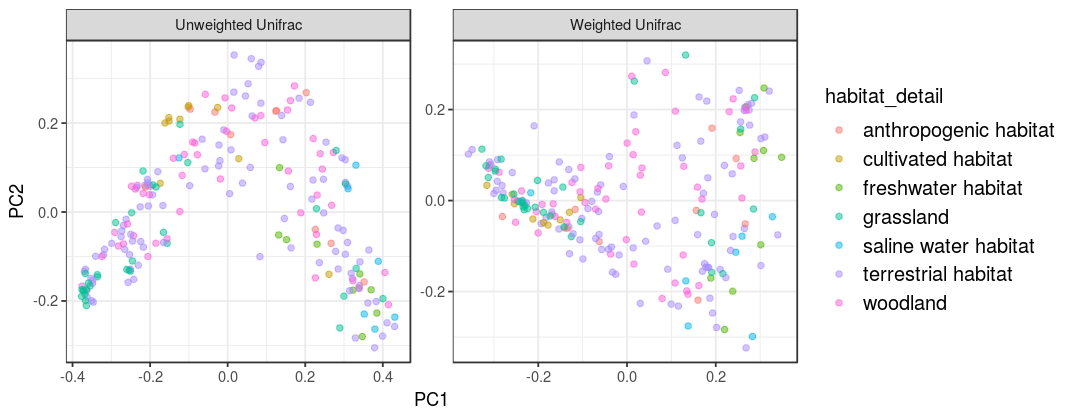

In [27]:
p_habitat_d = plot_pcoa(mds_j %>% filter(D %in% just_unifrac), 'habitat_detail')
options(repr.plot.width=9, repr.plot.height=3.5)
plot_write(p_habitat_d, file='IndD_pcoa-unifrac_habitat-detail.pdf')

## Formatting for iTOL

* plotting x-y points of beta-div

### uw-unifrac

In [28]:
# PC1 
mds_j_f = mds_j %>% 
    filter(D == 'Unweighted Unifrac') %>%
    dplyr::select(-D) %>%
    mutate(PC1 = PC1 + abs(min(PC1))) %>%
    group_by(scientific_name) %>%
    summarize(PC1_min = min(PC1),
              PC1_q1 = quantile(PC1, 0.25),
              PC1_median = median(PC1),
              PC1_q3 = quantile(PC1, 0.75),
              PC1_max = max(PC1)) %>%
    ungroup() %>%
    as.data.frame

rownames(mds_j_f) = mds_j_f$scientific_name
mds_j_f$scientific_name = NULL

mds_j_f %>% dfhead

[1] 128   5


,PC1_min,PC1_q1,PC1_median,PC1_q3,PC1_max
Acrocephalus_scirpaceus,0.60264700,0.60264700,0.60264700,0.60264700,0.60264700
Aepyceros_melampus,0.08559285,0.08559285,0.08559285,0.08559285,0.08559285
Anas_platyrhynchos,0.62425534,0.62425534,0.62425534,0.62425534,0.62425534


In [29]:
f = file.path(work_dir, 'SpecD_itol-box_uwUnif-PC1.txt')
itol_boxplot(mds_j_f, 'uwUnif_PC1', out_file=f)

File written: /ebio/abt3_projects/Georg_animal_feces/data/modulating_factors/ordination/IndD//SpecD_itol-box_uwUnif-PC1.txt 


In [30]:
# PC2
mds_j_f = mds_j %>% 
    filter(D == 'Unweighted Unifrac') %>%
    dplyr::select(-D) %>%
    mutate(PC2 = PC2 + abs(min(PC2))) %>%
    group_by(scientific_name) %>%
    summarize(PC2_min = min(PC2),
              PC2_q1 = quantile(PC2, 0.25),
              PC2_median = median(PC2),
              PC2_q3 = quantile(PC2, 0.75),
              PC2_max = max(PC2)) %>%
    ungroup() %>%
    as.data.frame

rownames(mds_j_f) = mds_j_f$scientific_name
mds_j_f$scientific_name = NULL

mds_j_f %>% dfhead

[1] 128   5


,PC2_min,PC2_q1,PC2_median,PC2_q3,PC2_max
Acrocephalus_scirpaceus,0.2660465,0.2660465,0.2660465,0.2660465,0.2660465
Aepyceros_melampus,0.2592569,0.2592569,0.2592569,0.2592569,0.2592569
Anas_platyrhynchos,0.3032960,0.3032960,0.3032960,0.3032960,0.3032960


In [31]:
f = file.path(work_dir, 'SpecD_itol-box_uwUnif-PC2.txt')
itol_boxplot(mds_j_f, 'uwUnif_PC2', out_file=f)

File written: /ebio/abt3_projects/Georg_animal_feces/data/modulating_factors/ordination/IndD//SpecD_itol-box_uwUnif-PC2.txt 


### w-unifrac

In [32]:
# PC1 
mds_j_f = mds_j %>% 
    filter(D == 'Weighted Unifrac') %>%
    dplyr::select(-D) %>%
    mutate(PC1 = PC1 + abs(min(PC1))) %>%
    group_by(scientific_name) %>%
    summarize(PC1_min = min(PC1),
              PC1_q1 = quantile(PC1, 0.25),
              PC1_median = median(PC1),
              PC1_q3 = quantile(PC1, 0.75),
              PC1_max = max(PC1)) %>%
    ungroup() %>%
    as.data.frame

rownames(mds_j_f) = mds_j_f$scientific_name
mds_j_f$scientific_name = NULL

mds_j_f %>% dfhead

[1] 128   5


,PC1_min,PC1_q1,PC1_median,PC1_q3,PC1_max
Acrocephalus_scirpaceus,0.5135263,0.5135263,0.5135263,0.5135263,0.5135263
Aepyceros_melampus,0.3899065,0.3899065,0.3899065,0.3899065,0.3899065
Anas_platyrhynchos,0.5322849,0.5322849,0.5322849,0.5322849,0.5322849


In [33]:
f = file.path(work_dir, 'SpecD_itol-box_wUnif-PC1.txt')
itol_boxplot(mds_j_f, 'wUnif_PC1', out_file=f)

File written: /ebio/abt3_projects/Georg_animal_feces/data/modulating_factors/ordination/IndD//SpecD_itol-box_wUnif-PC1.txt 


In [34]:
# PC2
mds_j_f = mds_j %>% 
    filter(D == 'Weighted Unifrac') %>%
    dplyr::select(-D) %>%
    mutate(PC2 = PC2 + abs(min(PC2))) %>%
    group_by(scientific_name) %>%
    summarize(PC2_min = min(PC2),
              PC2_q1 = quantile(PC2, 0.25),
              PC2_median = median(PC2),
              PC2_q3 = quantile(PC2, 0.75),
              PC2_max = max(PC2)) %>%
    ungroup() %>%
    as.data.frame

rownames(mds_j_f) = mds_j_f$scientific_name
mds_j_f$scientific_name = NULL

mds_j_f %>% dfhead

[1] 128   5


,PC2_min,PC2_q1,PC2_median,PC2_q3,PC2_max
Acrocephalus_scirpaceus,0.3019655,0.3019655,0.3019655,0.3019655,0.3019655
Aepyceros_melampus,0.2981319,0.2981319,0.2981319,0.2981319,0.2981319
Anas_platyrhynchos,0.1849756,0.1849756,0.1849756,0.1849756,0.1849756


In [35]:
f = file.path(work_dir, 'SpecD_itol-box_wUnif-PC2.txt')
itol_boxplot(mds_j_f, 'wUnif_PC2', out_file=f)

File written: /ebio/abt3_projects/Georg_animal_feces/data/modulating_factors/ordination/IndD//SpecD_itol-box_wUnif-PC2.txt 


## Outliers

* Which samples deviate most from their category centroids?

In [39]:
# formating metdata
metadata_f = metadata %>% as.data.frame
rownames(metadata_f) = metadata_f$X.SampleID
metadata_f = metadata_f[labels(d[[1]]),]
metadata_f %>% dfhead

[1] 213 172


,X.SampleID,BarcodeSequence,LinkerPrimerSequence,Primer,ReversePrimer,Barcode_ID,sample_number,host_subject_id,host_german_name,host_common_name,⋯,Cornell_Dilution_DNA_Illumina,Num_Illumina,Num,sorting_454,comments_additional,DNA_box_20180622,sample_vol_20180622,sample_label_20180622,Description,collection_bin
X1.Eurasian.Beaver,X1.Eurasian.Beaver,ACTCACGGTATG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0049,1,1,Biber,Eurasian.Beaver,⋯,4,120,18,18,NA,1,20,1,NA,NA
X101.Horse,X101.Horse,ACGACGTCTTAG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0030,101,101,Hauspferd,Horse,⋯,16,344,160,160,NA,2,20,101,NA,NA
X102.Kulan,X102.Kulan,ACGAGTGCTATC,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0031,102,102,Khulan,Kulan,⋯,16,345,161,161,NA,2,20,102,NA,NA


In [40]:
# calc centroid distances
centroid_dist = function(name, d, groups){
    # beta dispersion
    x = vegan::betadisper(d[[name]], groups, type = "centroid")
    # distance from centroid
    cent_dist = x$distances %>% as.data.frame
    colnames(cent_dist) = c('centroid_distance')
    cent_dist$X.SampleID = rownames(cent_dist)
    cent_dist$group = groups
    cent_dist$D = name
    return(cent_dist)
}

### Taxonomy

In [41]:
# centroid distances
cent_dists = lapply(as.list(names(d)), centroid_dist, d=d, groups=metadata_f$class)
cent_dists = do.call(rbind, cent_dists)
cent_dists = cent_dists %>%
    inner_join(metadata_f %>% select(X.SampleID, order, family, genus),
               c('X.SampleID'))
cent_dists %>% dfhead

[1] 852   7


centroid_distance,X.SampleID,group,D,order,family,genus
0.7127780,X1.Eurasian.Beaver,Mammalia,bray_curtis,Rodentia,Castoridae,Castor
0.7012063,X101.Horse,Mammalia,bray_curtis,Perissodactyla,Equidae,Equus
0.6892199,X102.Kulan,Mammalia,bray_curtis,Perissodactyla,Equidae,Equus


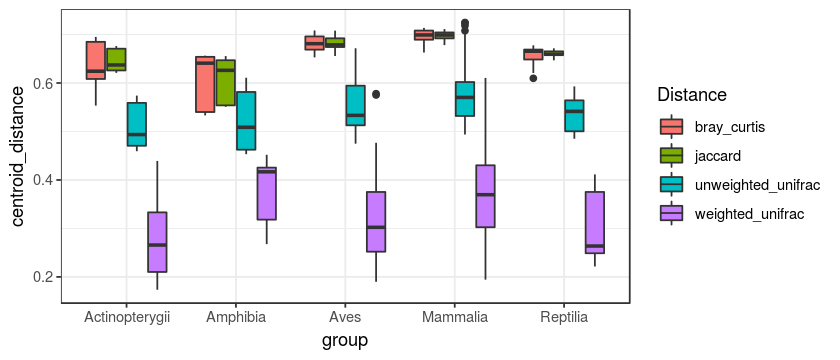

In [42]:
# boxplots of distances
p = ggplot(cent_dists, aes(group, centroid_distance, fill=D)) +
    geom_boxplot() +
    scale_fill_discrete('Distance') +
    theme_bw() 

options(repr.plot.width=7, repr.plot.height=3)
plot(p)

In [43]:
# just top 10 most distant
to_keep = c('unweighted_unifrac', 'weighted_unifrac')
cent_dists_top10 = cent_dists %>%
    filter(D %in% to_keep) %>%
    group_by(group, D) %>%
    top_n(10, centroid_distance) %>%
    mutate(mean_cent_dist = mean(centroid_distance)) %>%
    ungroup() %>%
    mutate(X.SampleID = X.SampleID %>% reorder(-mean_cent_dist),
           D = gsub('_', '\n', D))
    
cent_dists_top10 %>% dfhead

[1] 86  8


centroid_distance,X.SampleID,group,D,order,family,genus,mean_cent_dist
0.5733892,X157.Grey.Heron,Aves,unweighted unifrac,Ciconiiformes,Ardeidae,Ardea,0.6210897
0.4821749,X188.Brook.Trout,Actinopterygii,unweighted unifrac,Salmoniformes,Salmonidae,Salvelinus,0.5099931
0.5585157,X190.Common.House.Gecko,Reptilia,unweighted unifrac,Squamata,Gekkonidae,Hemidactylus,0.5397459


File written: /ebio/abt3_projects/Georg_animal_feces/notebooks/16S/3_modulating_factors/ordination/.figures/IndD_class-centroid-dist_outliers-t10.pdf 


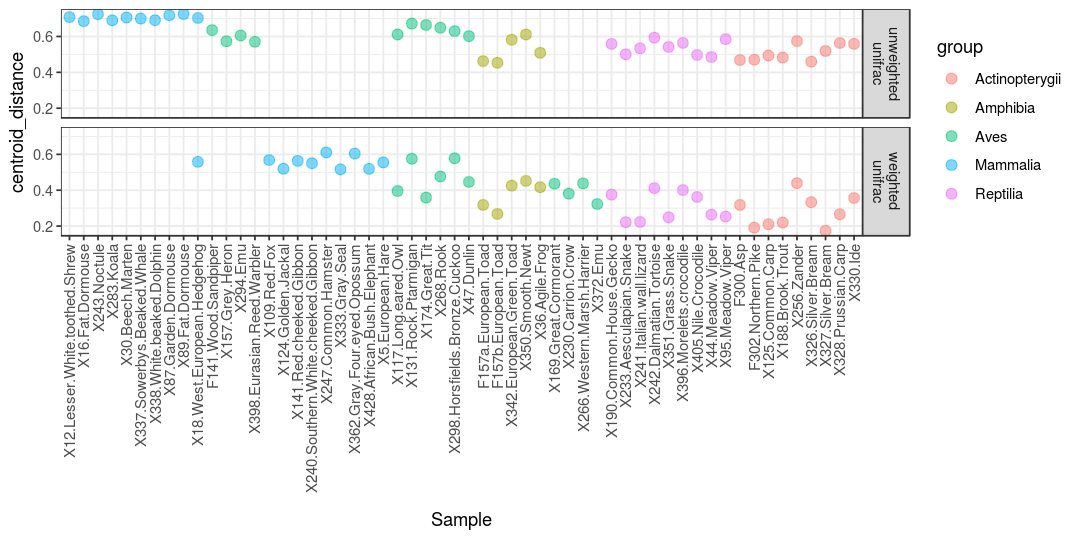

In [44]:
# pulling out outliers 
p = ggplot(cent_dists_top10, aes(X.SampleID, centroid_distance, color=group)) +
    geom_point(alpha=0.5, size=2.7) +
    facet_grid(D ~ .) +
    labs(x='Sample') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5, size=9)
    )
    
options(repr.plot.width=9, repr.plot.height=4.5)
plot_write(p, file='IndD_class-centroid-dist_outliers-t10.pdf')

### Diet

In [45]:
# centroid distances
cent_dists = lapply(as.list(names(d)), centroid_dist, d=d, groups=metadata_f$diet)
cent_dists = do.call(rbind, cent_dists)
cent_dists = cent_dists %>%
    inner_join(metadata_f %>% select(X.SampleID, class, order, family, genus),
               c('X.SampleID'))
cent_dists %>% dfhead

[1] 852   8


centroid_distance,X.SampleID,group,D,class,order,family,genus
0.7201909,X1.Eurasian.Beaver,herbivore,bray_curtis,Mammalia,Rodentia,Castoridae,Castor
0.7007890,X101.Horse,herbivore,bray_curtis,Mammalia,Perissodactyla,Equidae,Equus
0.6772008,X102.Kulan,herbivore,bray_curtis,Mammalia,Perissodactyla,Equidae,Equus


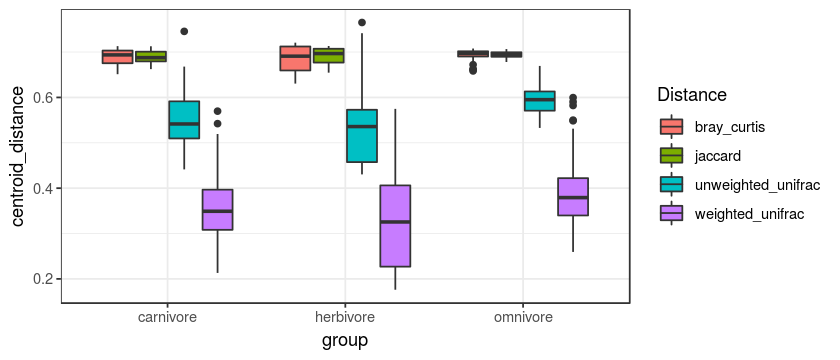

In [46]:
# boxplots of distances
p = ggplot(cent_dists, aes(group, centroid_distance, fill=D)) +
    geom_boxplot() +
    scale_fill_discrete('Distance') +
    theme_bw() 

options(repr.plot.width=7, repr.plot.height=3)
plot(p)

In [47]:
# just top 10 most distant
cent_dists_top10 = cent_dists %>%
    group_by(group, D) %>%
    top_n(10, centroid_distance) %>%
    mutate(mean_cent_dist = mean(centroid_distance)) %>%
    ungroup() %>%
    mutate(X.SampleID = X.SampleID %>% reorder(-mean_cent_dist),
           D = gsub('_', '\n', D))
    
cent_dists_top10 %>% dfhead

[1] 120   9


centroid_distance,X.SampleID,group,D,class,order,family,genus,mean_cent_dist
0.7201909,X1.Eurasian.Beaver,herbivore,bray curtis,Mammalia,Rodentia,Castoridae,Castor,0.7180503
0.7076751,X155.Long.tailed.Field.Mouse,omnivore,bray curtis,Mammalia,Rodentia,Muridae,Apodemus,0.7066389
0.7098590,X188.Brook.Trout,carnivore,bray curtis,Actinopterygii,Salmoniformes,Salmonidae,Salvelinus,0.7107479


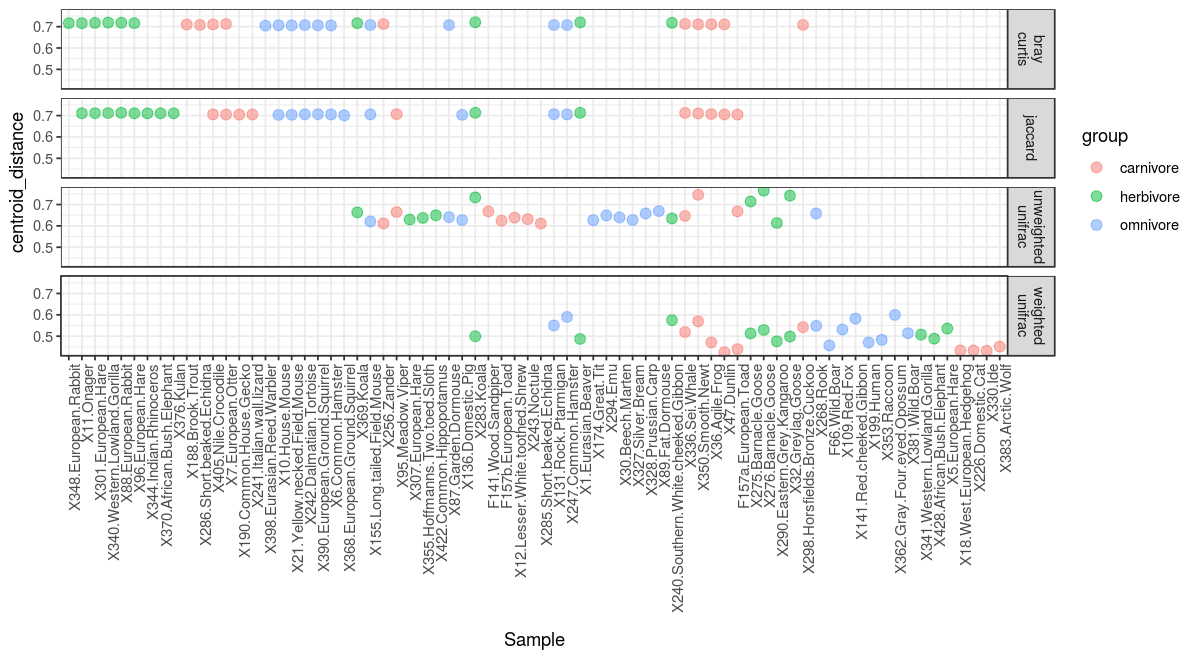

In [48]:
# pulling out outliers 
p = ggplot(cent_dists_top10, aes(X.SampleID, centroid_distance, color=group)) +
    geom_point(alpha=0.5, size=2.7) +
    facet_grid(D ~ .) +
    labs(x='Sample') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=90, hjust=1, size=9)
    )
    
options(repr.plot.width=10, repr.plot.height=5.5)
plot(p)

In [49]:
# just top 10 most distant
to_keep = c('unweighted_unifrac', 'weighted_unifrac')
cent_dists_top10 = cent_dists %>%
    filter(D %in% to_keep) %>%
    group_by(group, D) %>%
    top_n(10, centroid_distance) %>%
    mutate(mean_cent_dist = mean(centroid_distance)) %>%
    ungroup() %>%
    mutate(X.SampleID = X.SampleID %>% reorder(-mean_cent_dist),
           D = gsub('_', '\n', D))
    
cent_dists_top10 %>% dfhead

[1] 60  9


centroid_distance,X.SampleID,group,D,class,order,family,genus,mean_cent_dist
0.6273725,X136.Domestic.Pig,omnivore,unweighted unifrac,Mammalia,Artiodactyla,Suidae,Sus,0.6417274
0.6208569,X155.Long.tailed.Field.Mouse,omnivore,unweighted unifrac,Mammalia,Rodentia,Muridae,Apodemus,0.6417274
0.6114757,X256.Zander,carnivore,unweighted unifrac,Actinopterygii,Perciformes,Percidae,Sander,0.6509582


File written: /ebio/abt3_projects/Georg_animal_feces/notebooks/16S/3_modulating_factors/ordination/.figures/IndD_diet-centroid-dist_outliers-t10.pdf 


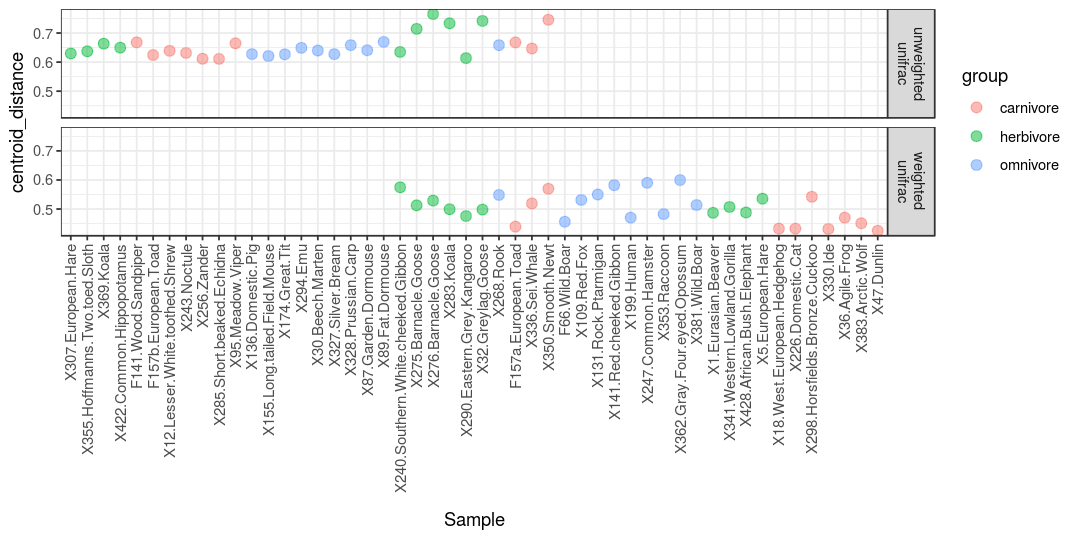

In [50]:
# pulling out outliers 
p = ggplot(cent_dists_top10, aes(X.SampleID, centroid_distance, color=group)) +
    geom_point(alpha=0.5, size=2.7) +
    facet_grid(D ~ .) +
    labs(x='Sample') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5, size=9)
    )
    
options(repr.plot.width=9, repr.plot.height=4.5)
plot_write(p, file='IndD_diet-centroid-dist_outliers-t10.pdf')

File written: /ebio/abt3_projects/Georg_animal_feces/notebooks/16S/3_modulating_factors/ordination/.figures/IndD_diet-centroid-dist_outliers-t10_parsed.pdf 


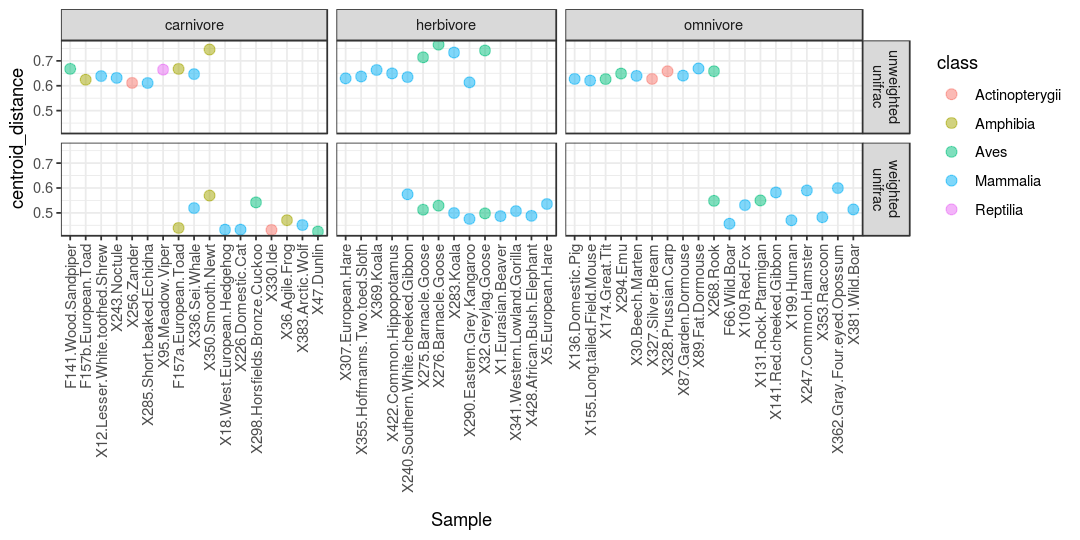

In [51]:
# pulling out outliers 
p = ggplot(cent_dists_top10, aes(X.SampleID, centroid_distance, color=class)) +
    geom_point(alpha=0.5, size=2.7) +
    facet_grid(D ~ group, scales='free_x', space='free_x') +
    labs(x='Sample') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5, size=9)
    )
    
options(repr.plot.width=9, repr.plot.height=4.5)
plot_write(p, file='IndD_diet-centroid-dist_outliers-t10_parsed.pdf')

### digestive system

In [52]:
# centroid distances
x = metadata_f %>%
    mutate(digestive_system = digestive_system %>% as.character,
           digestive_system = ifelse(is.na(digestive_system), 'NA', digestive_system)) %>%
    .$digestive_system

cent_dists = lapply(as.list(names(d)), centroid_dist, d=d, groups=x)
cent_dists = do.call(rbind, cent_dists)
cent_dists = cent_dists %>%
    inner_join(metadata_f %>% select(X.SampleID, class, order, family, genus),
               c('X.SampleID'))

cent_dists %>% dfhead

[1] 852   8


centroid_distance,X.SampleID,group,D,class,order,family,genus
0.7052485,X1.Eurasian.Beaver,hindgut,bray_curtis,Mammalia,Rodentia,Castoridae,Castor
0.6762899,X101.Horse,hindgut,bray_curtis,Mammalia,Perissodactyla,Equidae,Equus
0.7021678,X102.Kulan,hindgut,bray_curtis,Mammalia,Perissodactyla,Equidae,Equus


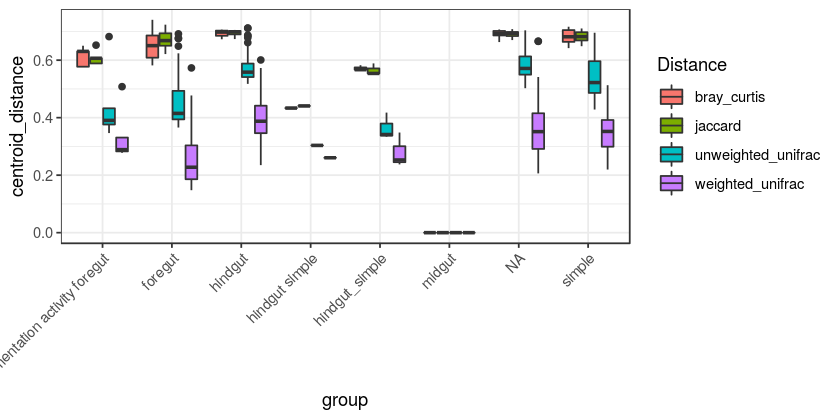

In [53]:
# boxplots of distances
p = ggplot(cent_dists, aes(group, centroid_distance, fill=D)) +
    geom_boxplot() +
    scale_fill_discrete('Distance') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

options(repr.plot.width=7, repr.plot.height=3.5)
plot(p)

In [54]:
# just top 10 most distant
to_keep = c('unweighted_unifrac', 'weighted_unifrac')
cent_dists_top10 = cent_dists %>%
    filter(D %in% to_keep) %>%
    group_by(group, D) %>%
    top_n(10, centroid_distance) %>%
    mutate(mean_cent_dist = mean(centroid_distance)) %>%
    ungroup() %>%
    mutate(X.SampleID = X.SampleID %>% reorder(-mean_cent_dist),
           D = gsub('_', '\n', D))
    
cent_dists_top10 %>% dfhead

[1] 102   9


centroid_distance,X.SampleID,group,D,class,order,family,genus,mean_cent_dist
0.3413759,X122.Wild.Boar,hindgut_simple,unweighted unifrac,Mammalia,Artiodactyla,Suidae,Sus,0.3642797
0.5475215,X133.Domestic.Goat,foregut,unweighted unifrac,Mammalia,Artiodactyla,Bovidae,Capra,0.6096182
0.4175531,X136.Domestic.Pig,hindgut_simple,unweighted unifrac,Mammalia,Artiodactyla,Suidae,Sus,0.3642797


File written: /ebio/abt3_projects/Georg_animal_feces/notebooks/16S/3_modulating_factors/ordination/.figures/IndD_dig-sys-centroid-dist_outliers-t10.pdf 


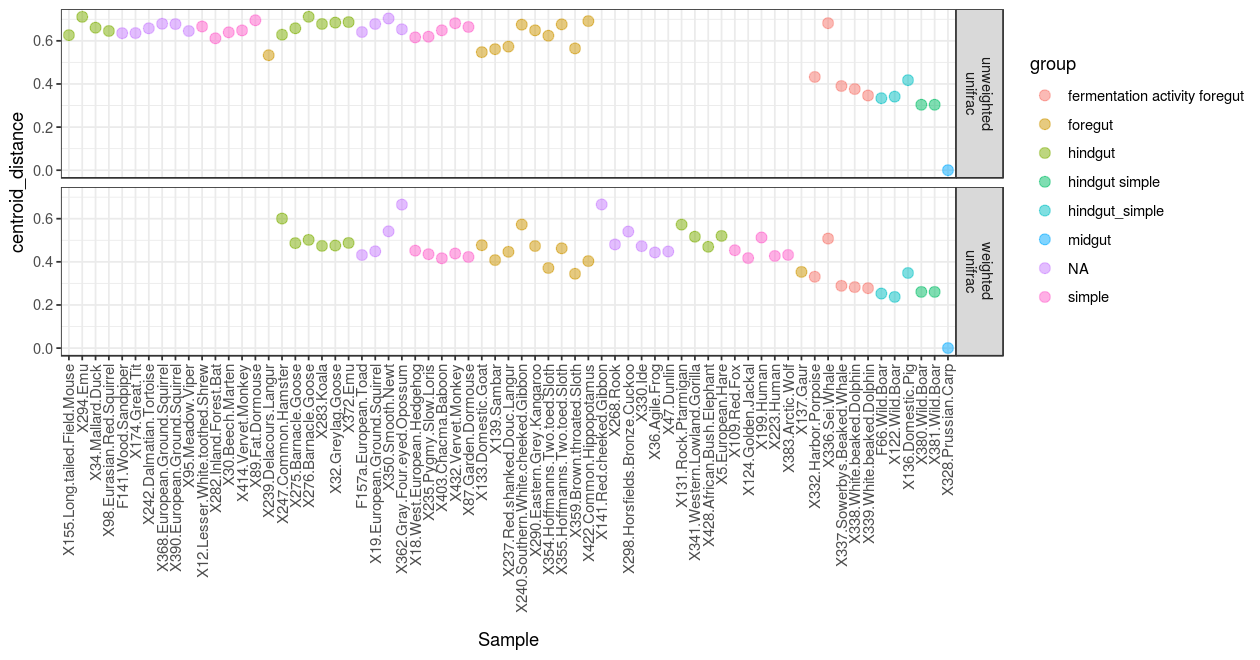

In [55]:
# pulling out outliers 
p = ggplot(cent_dists_top10, aes(X.SampleID, centroid_distance, color=group)) +
    geom_point(alpha=0.5, size=2.7) +
    facet_grid(D ~ .) +
    labs(x='Sample') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5, size=9)
    )
    
options(repr.plot.width=10.5, repr.plot.height=5.5)
plot_write(p, file='IndD_dig-sys-centroid-dist_outliers-t10.pdf')

File written: /ebio/abt3_projects/Georg_animal_feces/notebooks/16S/3_modulating_factors/ordination/.figures/IndD_dig-sys-centroid-dist_outliers-t10.pdf 


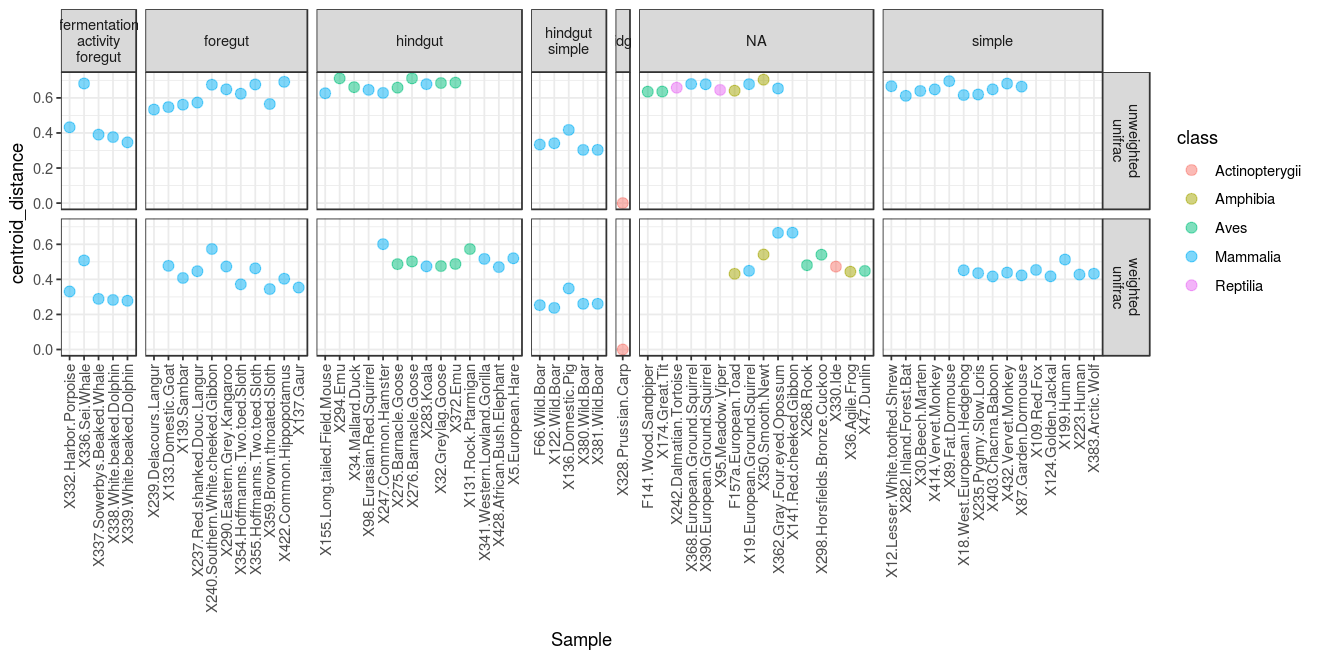

In [56]:
# pulling out outliers 
p = ggplot(cent_dists_top10 %>% 
               mutate(group = gsub(' ', '\n', group),
                      group = gsub('_', '\n', group)),
            aes(X.SampleID, centroid_distance, color=class)) +
    geom_point(alpha=0.5, size=2.7) +
    facet_grid(D ~ group, scales='free_x', space='free_x') +
    labs(x='Sample') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5, size=9)
    )
    
options(repr.plot.width=11, repr.plot.height=5.5)
plot_write(p, file='IndD_dig-sys-centroid-dist_outliers-t10.pdf')

#### explore

In [57]:
# explore
metadata_f %>%
    filter(grepl('fermentation', digestive_system))

X.SampleID,BarcodeSequence,LinkerPrimerSequence,Primer,ReversePrimer,Barcode_ID,sample_number,host_subject_id,host_german_name,host_common_name,⋯,Cornell_Dilution_DNA_Illumina,Num_Illumina,Num,sorting_454,comments_additional,DNA_box_20180622,sample_vol_20180622,sample_label_20180622,Description,collection_bin
X337.Sowerbys.Beaked.Whale,ACGCTCATGGAT,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0037,337,337,Sowerby-Zweizahnwal,Sowerbys.Beaked.Whale,⋯,1,87,410,410,live stranded_freshly dead- died on beach /code 2a,5,20,337,NA,NA
X338.White.beaked.Dolphin,ACGGATCGTCAG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0038,338,338,Weissschnauzendelfin,White.beaked.Dolphin,⋯,1,88,411,411,live stranded_freshly dead- died on beach /code 2a,5,20,338,NA,NA
X332.Harbor.Porpoise,ACGCAACTGCTA,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0033,332,332,Gewoehnliche Schweinswal,Harbor.Porpoise,⋯,4,256,405,405,dead stranded_freshly dead /code 2a,5,20,332,NA,NA
X336.Sei.Whale,ACGCTATCTGGA,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0036,336,336,Seiwal,Sei.Whale,⋯,4,258,409,409,live stranded_freshly dead- died on beach /code 2a,5,20,336,NA,NA
X339.White.beaked.Dolphin,ACGGTGAGTGTC,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0039,339,339,Weissschnauzendelfin,White.beaked.Dolphin,⋯,4,259,412,412,live stranded_freshly dead- died on beach /code 2a,5,20,339,NA,NA


# sessionInfo

In [58]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.1 LTS

Matrix products: default
BLAS: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq/lib/R/lib/libRblas.so
LAPACK: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq/lib/R/lib/libRlapack.so

locale:
[1] en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] bindrcpp_0.2.2  phyloseq_1.22.3 stringr_1.3.1   ggplot2_3.0.0  
[5] tidyr_0.8.1     dplyr_0.7.6    

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.17        ape_5.1             lattice_0.20-34    
 [4] Biostrings_2.46.0   assertthat_0.2.0    digest_0.6.15      
 [7] foreach_1.4.4       IRdisplay_0.4.4     R6_2.2.2           
[10] plyr_1.8.4          repr_0.15.0         stats4_3.4.1       
[13] evaluate_0.10.1     pillar_1.2.2        zlibbioc_1.24.0    
[16] rlang_0.2.1         lazyeval_0.2.1      uuid_0.1-2         
